In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace
import datetime as dt

from numpy import genfromtxt

import sys
sys.path.append('../../models')
from models import firstordermodel, secondordermodel, thirdordermodel

sys.path.append('../')
from tools import stochasticSimulation, derive_regimes, discrete_ivp_solver, \
                    smooth_dap, sol_ivp_wrapper, sol_ivp_wrapper_discrete,\
                    smooth_regime, cost, sigmoid,\
                    simulate_MPC, mergeSwitchCont,\
                    build_initial_ipopt_object,\
                    consMatrix, f_with_consumption



%load_ext autoreload
%autoreload 2

# PATHS
FIGS = '/Users/madsobdrup/Dropbox/Skole/DTU/Studie/MASTER/THESIS/FIGS'

# Switching time optimization modules
import switching_times_1st as st1
import switching_times_1st_rk as st1_rk
import switching_times_2nd as st2

import lxml

k_baseline = 12400.
k_MELT = 250.
k_IDLE = 9.

In [2]:
# Define model
lambda_MELT = 0.00183*60
mu_MELT = 66.92400 
lambda_IDLE = 0.00085*60
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([lambda_MELT, mu_MELT, lambda_IDLE, mu_IDLE, sigma, R])
m1 = firstordermodel(pars)

tf = 60 * 24
x0 = np.array(90)


# Extract switch solution from C++
switches = genfromtxt('../results/optimal_pars.csv', delimiter=',')
tau_MELT_all, tau_IDLE_all  = derive_regimes(switches,tf,1)
tau_MELT, tau_IDLE = derive_regimes(switches,tf,0)
switches = np.concatenate((tau_MELT, tau_IDLE))
switches[-1 ] += 0.1 # To avoid duplicate

# Draw random switches in the format [tau_melt, tau_idle]
#np.random.seed(1234)
#n_s = 5
#switch = np.sort(np.random.uniform(0,tf,2*n_s))
#switch = np.concatenate(derive_regimes(switch,0,0))
#switch

# Define model
mu_IDLE = 957.10401120
mu_MELT = 700.74438030
omega_IDLE = 0.05220237
omega_MELT = 0.30504764
xi_IDLE = 0.18367929
xi_MELT = 0.50240445 
slope = 0.00778941
offset = 599.12794983
logsigma = np.array([-0.44650699, 2.53627662])
logR = -10.86389382

pars = np.array([mu_IDLE, mu_MELT, omega_IDLE, omega_MELT, xi_IDLE, xi_MELT, slope, offset, logsigma, logR])
m2 = secondordermodel(pars)

In [3]:
regulation = pd.read_csv('../../data/realtimemarket.csv',header=0, index_col=0,skiprows = 0)
regulation = regulation.loc[regulation['PriceArea'] == 'DK1']
regulation = regulation[{'BalancingPowerPriceDownEUR','BalancingPowerPriceUpEUR'}]
regulation.index = pd.to_datetime(regulation.index)
regulation = regulation.reindex(index=regulation.index[::-1])

spot = pd.read_csv('../../data/elspotprices.csv',header=0, index_col=0,skiprows = 0)
spot = spot.loc[spot['PriceArea'] == 'DK1']
spot = spot[{'SpotPriceEUR'}]
spot.index = pd.to_datetime(spot.index)
spot = spot.reindex(index=spot.index[::-1])

prices = pd.concat([spot, regulation], axis=1, join='inner')
prices.columns = ['spot', 'up', 'down']
#prices = prices * 1e-6


# Make correct round off
num_deci = 2
prices_og = prices
prices = np.round(np.round(prices_og * 10**num_deci,num_deci) / 10**num_deci,num_deci) #= np.round(prices,3)

# Derive markets
tol = 1e-2

prices['market_spot'] = 0
prices['market_down'] = 0
prices['market_up'] = 0

# When both up and down is less than tol away from the spot price
prices.loc[(np.abs(np.round(prices['spot'] - prices['down'],2)) <= tol) & (np.abs(np.round(prices['spot'] - prices['up'],2)) <= tol),'market_spot'] = 1

# When both are different, but even the smallest is bigger than 0.1 we have an error. Put it to spot market
prices.loc[np.minimum(np.abs(prices['spot'] - prices['up']),np.abs(prices['spot'] - prices['down'])) > 0.1,'market_spot'] = 1


prices.loc[(prices['market_spot'] != 1) & (np.abs(np.round(prices['spot'] - prices['down'],2)) > np.abs(np.round(prices['spot'] - prices['up'],2))),'market_down'] = 1
prices.loc[(prices['market_spot'] != 1) & (np.abs(np.round(prices['spot'] - prices['down'],2)) <= np.abs(np.round(prices['spot'] - prices['up'],2))),'market_up'] = 1


frac_down = np.mean(prices['market_down'])
frac_spot = np.mean(prices['market_spot'])
frac_up = np.mean(prices['market_up'])

[frac_down, frac_spot, frac_up], np.sum([frac_down, frac_spot, frac_up])




([0.2864390060594673, 0.2907839729437738, 0.4227770209967589], 1.0)

In [4]:
nswitches = 10
tf_sim = 60 * 24
tf_ph = 60 * 48


# ------ Define models -------

# "True" model
# -------------
#system_true = m1; x0_true = np.array([90])
system_true = m2; x0_true = np.array([2.6659426, 899.8884004])
# -------------

# Expectation model
# -------------
system_model = m1; x0_model = np.array([90.])
#system_model = m2; x0_model = np.array([2.6659426, 899.8884004])
# -------------

# Optimization object
# -------------
tank = st1_rk.plant(); tank_pars = m1.drift_pars
#tank = st2.plant(), tank_pars = m1.drift_pars
# -------------

# Define optimization parameters
max_melt = 16. * 60.
dt_opt = 0.1
n_s = 10
t0 = 0.
opt_rk = True
tank = build_initial_ipopt_object(tank, tank_pars, dt_opt, k_baseline, k_MELT, k_IDLE, t0, tf_ph, max_melt, n_s, opt_rk)

#tank.get_p_optimize()

In [5]:
# Build initial values - Other methods could be considered
idle = tf * np.linspace(0.1,0.9,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.2 # Assign melt period to a little before idle
switch0_dap = np.concatenate((melt,idle)) # put together

idle = tf * np.linspace(0.05,0.85,n_s) # Spread out on the whole interval
melt = idle - max_melt/n_s * 0.2 # Assign melt period to a little before idle
switch0_rk = np.concatenate((melt,idle)) # put together

switch0 = np.concatenate((switch0_dap,switch0_rk))
switch0

tank.set_p_optimize(switch0)

In [6]:
switch0

array([ 124.8,  252.8,  380.8,  508.8,  636.8,  764.8,  892.8, 1020.8,
       1148.8, 1276.8,  144. ,  272. ,  400. ,  528. ,  656. ,  784. ,
        912. , 1040. , 1168. , 1296. ,   52.8,  180.8,  308.8,  436.8,
        564.8,  692.8,  820.8,  948.8, 1076.8, 1204.8,   72. ,  200. ,
        328. ,  456. ,  584. ,  712. ,  840. ,  968. , 1096. , 1224. ])

In [7]:
switch0[0]

124.8

In [8]:
tank.get_p_dynamic()[10]

-1.0

In [9]:
# Simulation options
start_date = '2015-05-09 19:00:00'
n_days = 2
dt_sim = 0.01
seed = 1233
save_to_file = 1

day = 0
idx_offset = np.where(prices.index == start_date)[0][0]
start_model = x0_model

In [10]:
idx = np.arange(48) + day * 48 + idx_offset
future_days = np.array(prices.index[idx])
#future_hours = np.array(prices['Hours'][idx])
future_price = np.array(prices['spot'][idx]).astype(np.float) * 1/1000000


# ---------------------------
# Compute optimal switches over 2 days
# ---------------------------

# -- Set new optimization object

# Initial state of the system
tank.set_x0(np.append(start_model,0)) 

# Update prices
p_dynamic = tank.get_p_dynamic()
for k in range(0, 48):
    p_dynamic[k] = future_price[k]
tank.set_p_dynamic(p_dynamic)

print(tank.get_p_dynamic()[10] * 10000)



opt = tank.get_p_optimize()
# Solve
tank.solve()

0.09960000000000001


In [11]:
print(tank.get_p_dynamic()[10] * 10000)

0.09960000000000001


In [12]:
tf_ph = 60 * 48

In [29]:
#x0 = np.array(x0)
t0_sub = 0.
tf_sub = tf_ph/48.
total_time = tf_ph - t0

switch_dap = switch0_dap
model = system_model
q_dap = 100
x0_consumption_dap = np.concatenate((x0_model,np.array([0.])))

for k in range(15):
    x0_consumption_dap[1] = 0.
    T = np.linspace(t0_sub,tf_sub,1000)
    T_hour, X_dap = discrete_ivp_solver(f_with_consumption,x0_consumption_dap,switch_dap,T,tf_sub,extra_args=(model,q_dap,k_baseline,k_IDLE,k_MELT))
    
    t0_sub += total_time/48.
    tf_sub += total_time/48.
    
    x0_consumption_dap[0] = X_dap[0][-1]


X_dap[0][-1], X_dap[1][-1]

(79.56152984294285, 11619.870221745034)

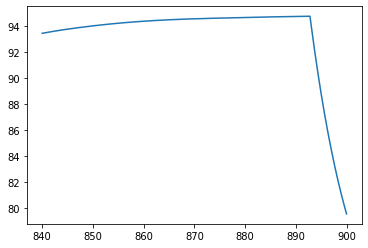

In [30]:
plt.plot(T_hour, X_dap[0])

In [15]:
total_time

2880.0

In [16]:
# 0  9.5225735e+00 0.00e+00 7.73e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00   0
#   1  9.5225563e+00 0.00e+00 6.07e-04  -2.8 1.51e-02    -  9.90e-01 1.00e+00f  1
#   2  9.5225352e+00 0.00e+00 7.70e-04  -4.8 1.93e-02    -  9.90e-01 1.00e+00f  1
#   3  9.5225140e+00 0.00e+00 7.73e-04  -6.8 1.93e-02    -  9.90e-01 1.00e+00f  1
#   4  9.5224927e+00 0.00e+00 7.73e-04  -8.8 1.93e-02    -  9.97e-01 1.00e+00f  1
#   5  9.5224715e+00 0.00e+00 7.73e-04  -7.5 1.93e-02    -  1.00e+00 1.00e+00f  1